## Overview
- You will perform electricity demand forecasting using the data provided in a Google Colaboratory notebook.
- The provided data consists of two types:
  - electricity_demand.csv: Electricity demand values within the Kansai Electric Power (JP) jurisdiction.
  - {location}.csv: Actual weather data for specific locations.
- The forecasting target period is January 1, 2023, 00:00:00 – December 31, 2023, 23:00:00.
- Electricity demand values can only be used up until 23:00:00 of the day before the target date.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
# Load Electricity Demand Data
demand_df = pd.read_csv('C:/Users/junjo/Music/propractice/jupyter/projects/electricity_demand/data/electricity/demand.csv', parse_dates=['datetime'])
demand_df

,datetime,actual_performance(10000 kW)
0,2021-01-01 00:00:00,1571
1,2021-01-01 01:00:00,1492
2,2021-01-01 02:00:00,1453
3,2021-01-01 03:00:00,1412
4,2021-01-01 04:00:00,1358
...,...,...
26275,2023-12-31 19:00:00,1427
26276,2023-12-31 20:00:00,1392
26277,2023-12-31 21:00:00,1348
26278,2023-12-31 22:00:00,1288


In [4]:
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   datetime                      26280 non-null  datetime64[ns]
 1   actual_performance(10000 kW)  26280 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 410.8 KB


In [5]:
demand_df.isnull().sum()

datetime                        0
actual_performance(10000 kW)    0
dtype: int64

In [7]:
# Load and Merge Multiple Weather Files
weather_files = glob.glob("C:/Users/junjo/Music/propractice/jupyter/projects/electricity_demand/data/Weather/*.csv")  # Get all CSV files in directory
#weather_files.remove('/content/demand.csv')  # Exclude demand file

weather_dfs = []
for file in weather_files:
    df = pd.read_csv(file, parse_dates=['datetime'])
    df['location'] = file.split('/')[-1].replace('.csv', '')  # Add location column
    weather_dfs.append(df)

weather_df = pd.concat(weather_dfs, ignore_index=True)  # Combine all weather data

C:\Users\junjo\AppData\Local\Temp\ipykernel_2828\1383248357.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weather_df = pd.concat(weather_dfs, ignore_index=True)  # Combine all weather data


In [8]:
weather_df

,datetime,precipitation,temperature,dew_point_temperature,humidity,wind_speed,wind_direction,snowfall,location
0,2021-01-01 00:00:00,0.0,0.3,-4.9,68.0,3.8,南,0.0,Weather\hikone
1,2021-01-01 01:00:00,0.0,0.3,-4.7,69.0,3.7,南南西,0.0,Weather\hikone
2,2021-01-01 02:00:00,0.0,0.0,-4.8,70.0,3.5,南南西,0.0,Weather\hikone
3,2021-01-01 03:00:00,0.0,-0.8,-4.7,75.0,2.3,南南東,0.0,Weather\hikone
4,2021-01-01 04:00:00,0.0,0.2,-4.0,73.0,2.5,南南西,0.0,Weather\hikone
...,...,...,...,...,...,...,...,...,...
183955,2023-12-31 19:00:00,0.0,11.3,4.3,62.0,7.6,西北西,0.0,Weather\wakayama
183956,2023-12-31 20:00:00,0.0,11.0,4.5,64.0,3.4,西北西,0.0,Weather\wakayama
183957,2023-12-31 21:00:00,0.0,10.8,5.2,68.0,7.8,西北西,0.0,Weather\wakayama
183958,2023-12-31 22:00:00,0.0,10.2,5.0,70.0,7.2,北西,0.0,Weather\wakayama


In [9]:
# Merge datasets on datetime
data = pd.merge(demand_df, weather_df, on='datetime', how='inner')
data

,datetime,actual_performance(10000 kW),precipitation,temperature,dew_point_temperature,humidity,wind_speed,wind_direction,snowfall,location
0,2021-01-01 00:00:00,1571,0.0,0.3,-4.9,68.0,3.8,南,0.0,Weather\hikone
1,2021-01-01 00:00:00,1571,0.0,2.2,-3.7,65.0,5.7,西,0.0,Weather\kobe
2,2021-01-01 00:00:00,1571,0.0,0.6,-5.0,66.0,2.1,南南西,0.0,Weather\kyoto
3,2021-01-01 00:00:00,1571,0.0,3.1,-4.1,59.0,4.8,西南西,0.0,Weather\osaka
4,2021-01-01 00:00:00,1571,0.0,3.7,-4.2,56.0,6.7,西北西,0.0,Weather\shionomisaki
...,...,...,...,...,...,...,...,...,...,...
183955,2023-12-31 23:00:00,1258,0.5,9.1,5.7,79.0,1.6,北西,0.0,Weather\kyoto
183956,2023-12-31 23:00:00,1258,0.0,10.0,5.0,71.0,1.8,西南西,0.0,Weather\osaka
183957,2023-12-31 23:00:00,1258,0.0,11.3,5.4,67.0,6.9,西,0.0,Weather\shionomisaki
183958,2023-12-31 23:00:00,1258,1.0,7.7,4.8,82.0,3.6,北北西,0.0,Weather\toyooka


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   datetime                      183960 non-null  datetime64[ns]
 1   actual_performance(10000 kW)  183960 non-null  int64         
 2   precipitation                 183960 non-null  float64       
 3   temperature                   183960 non-null  float64       
 4   dew_point_temperature         183960 non-null  float64       
 5   humidity                      183960 non-null  float64       
 6   wind_speed                    183960 non-null  float64       
 7   wind_direction                183960 non-null  object        
 8   snowfall                      183960 non-null  float64       
 9   location                      183960 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 14.0+ MB


In [11]:
data.describe()

,datetime,actual_performance(10000 kW),precipitation,temperature,dew_point_temperature,humidity,wind_speed,snowfall
count,183960,183960.000000,183960.000000,183960.000000,183960.000000,183960.000000,183960.000000,183960.000000
mean,2022-07-02 11:30:00,1616.426180,0.191283,17.073062,11.347242,70.890884,2.902551,0.004664
min,2021-01-01 00:00:00,955.000000,0.000000,-6.300000,-17.400000,0.000000,0.000000,0.000000
25%,2021-10-01 17:45:00,1359.000000,0.000000,10.000000,3.400000,58.000000,1.400000,0.000000
50%,2022-07-02 11:30:00,1572.000000,0.000000,17.400000,11.300000,72.000000,2.500000,0.000000
75%,2023-04-02 05:15:00,1816.000000,0.000000,24.500000,20.100000,85.000000,3.900000,0.000000
max,2023-12-31 23:00:00,2827.000000,64.000000,38.400000,28.000000,100.000000,22.500000,7.000000
std,NaN,328.181547,1.221273,8.673201,9.192269,17.184598,1.958721,0.103536


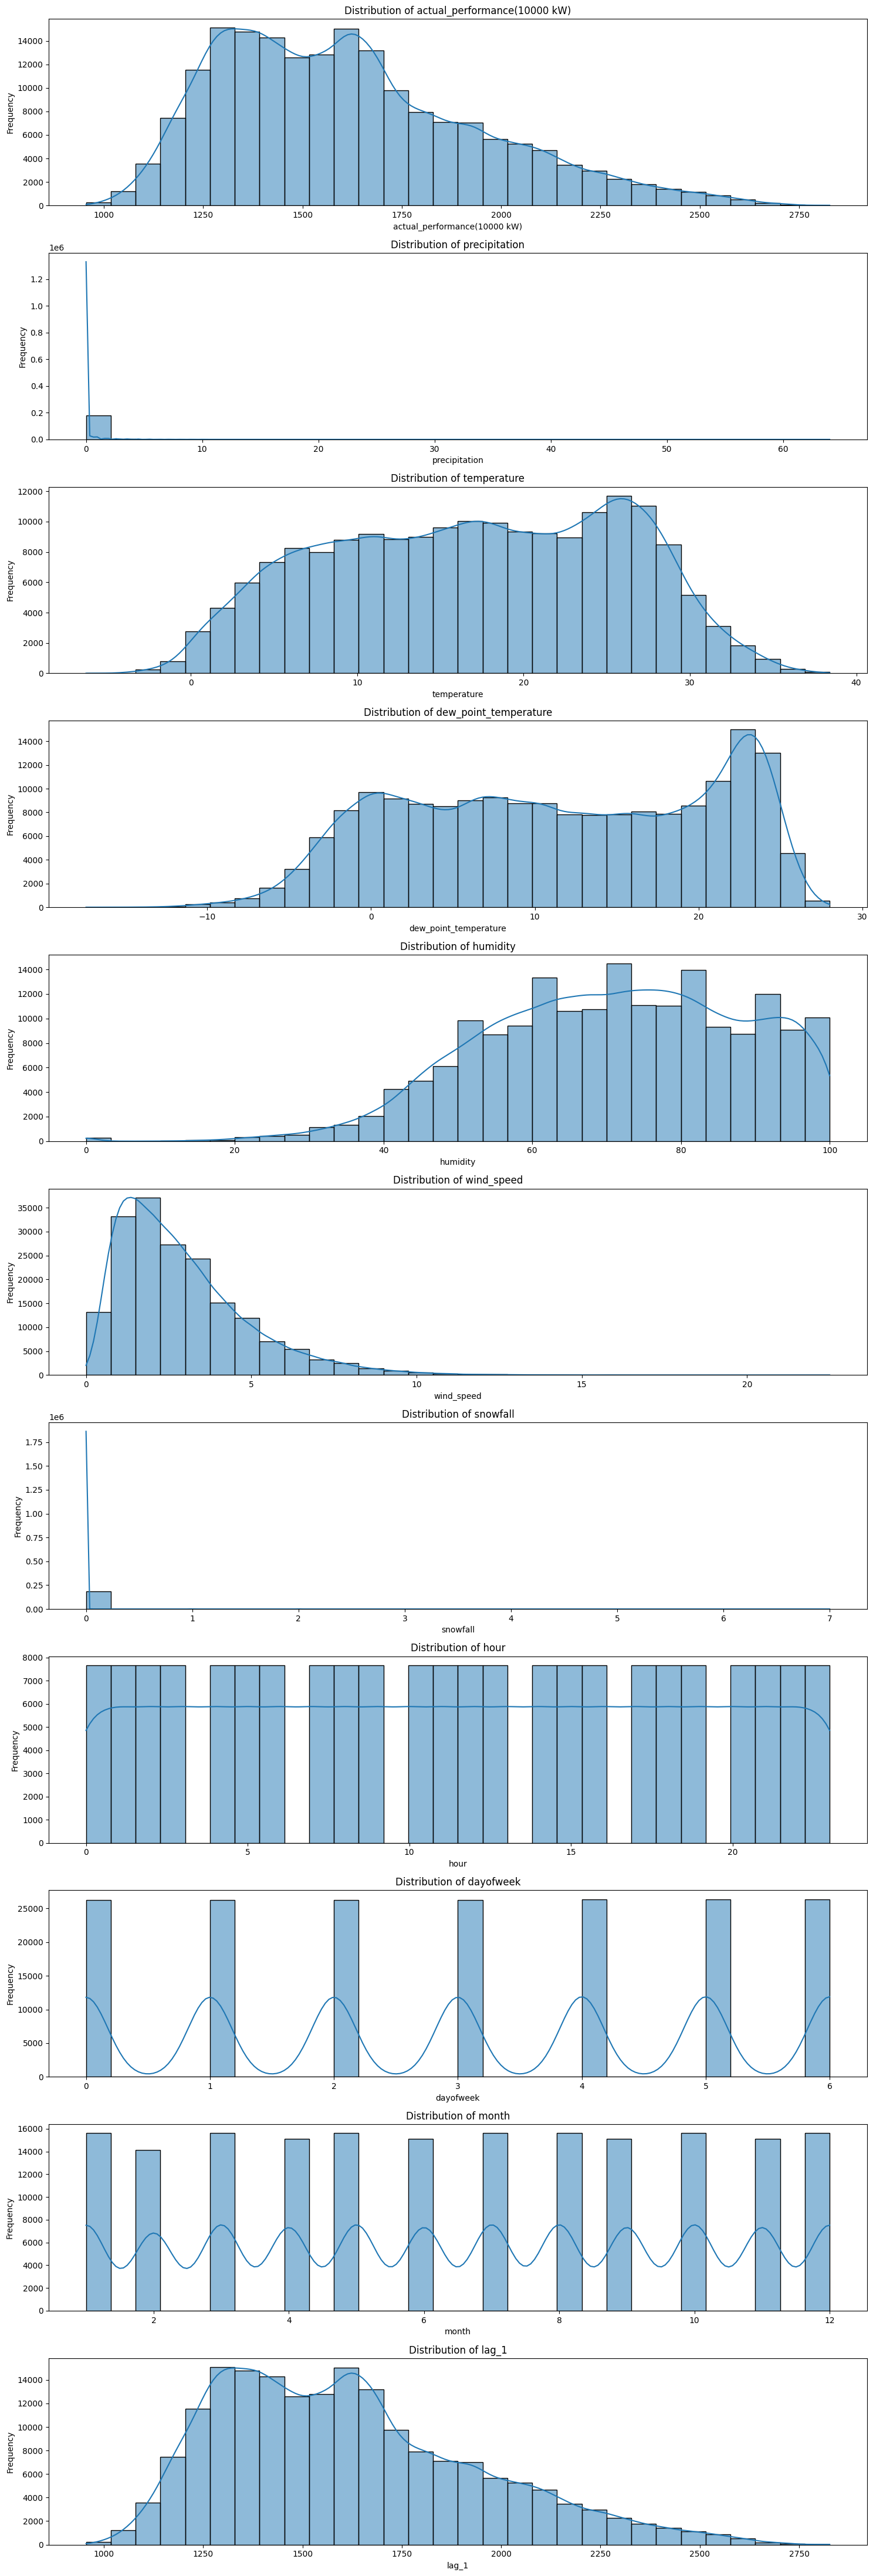

In [24]:
# Univariate Analysis
num_cols = data.select_dtypes(include=['number']).columns
num_plots = len(num_cols)
plt.figure(figsize=(15, num_plots * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(num_plots, 1, i)
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('univariate_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Extract unique wind direction values
unique_wind_directions = data['wind_direction'].unique()
print("Unique Wind Directions:", unique_wind_directions)

Unique Wind Directions: ['南' '西' '南南西' '西南西' '西北西' '南南東' '北' '北東' '南西' '北西' '北北西' '東南東' '東' '静穏'
 '南東' '東北東' '北北東' '西 )' '×' '北北西 )' '東北東 )']


In [14]:
wind_mapping = {
    '北': 'North', '南': 'South', '東': 'East', '西': 'West',
    '北東': 'Northeast', '北西': 'Northwest', '南東': 'Southeast', '南西': 'Southwest',
    '西南西': 'West-Southwest', '西北西': 'West-Northwest', '南南東': 'South-Southeast',
    '南南西': 'South-Southwest', '北北西': 'North-Northwest', '東南東': 'East-Southeast',
    '東北東': 'East-Northeast', '北北東': 'North-Northeast', '静穏': 'Calm',
    '西 )': 'West', '×': 'Unknown', '北北西 )': 'North-Northwest', '東北東 )': 'East-Northeast'
}
data['wind_direction'] = data['wind_direction'].map(wind_mapping)
data



,datetime,actual_performance(10000 kW),precipitation,temperature,dew_point_temperature,humidity,wind_speed,wind_direction,snowfall,location
0,2021-01-01 00:00:00,1571,0.0,0.3,-4.9,68.0,3.8,South,0.0,Weather\hikone
1,2021-01-01 00:00:00,1571,0.0,2.2,-3.7,65.0,5.7,West,0.0,Weather\kobe
2,2021-01-01 00:00:00,1571,0.0,0.6,-5.0,66.0,2.1,South-Southwest,0.0,Weather\kyoto
3,2021-01-01 00:00:00,1571,0.0,3.1,-4.1,59.0,4.8,West-Southwest,0.0,Weather\osaka
4,2021-01-01 00:00:00,1571,0.0,3.7,-4.2,56.0,6.7,West-Northwest,0.0,Weather\shionomisaki
...,...,...,...,...,...,...,...,...,...,...
183955,2023-12-31 23:00:00,1258,0.5,9.1,5.7,79.0,1.6,Northwest,0.0,Weather\kyoto
183956,2023-12-31 23:00:00,1258,0.0,10.0,5.0,71.0,1.8,West-Southwest,0.0,Weather\osaka
183957,2023-12-31 23:00:00,1258,0.0,11.3,5.4,67.0,6.9,West,0.0,Weather\shionomisaki
183958,2023-12-31 23:00:00,1258,1.0,7.7,4.8,82.0,3.6,North-Northwest,0.0,Weather\toyooka


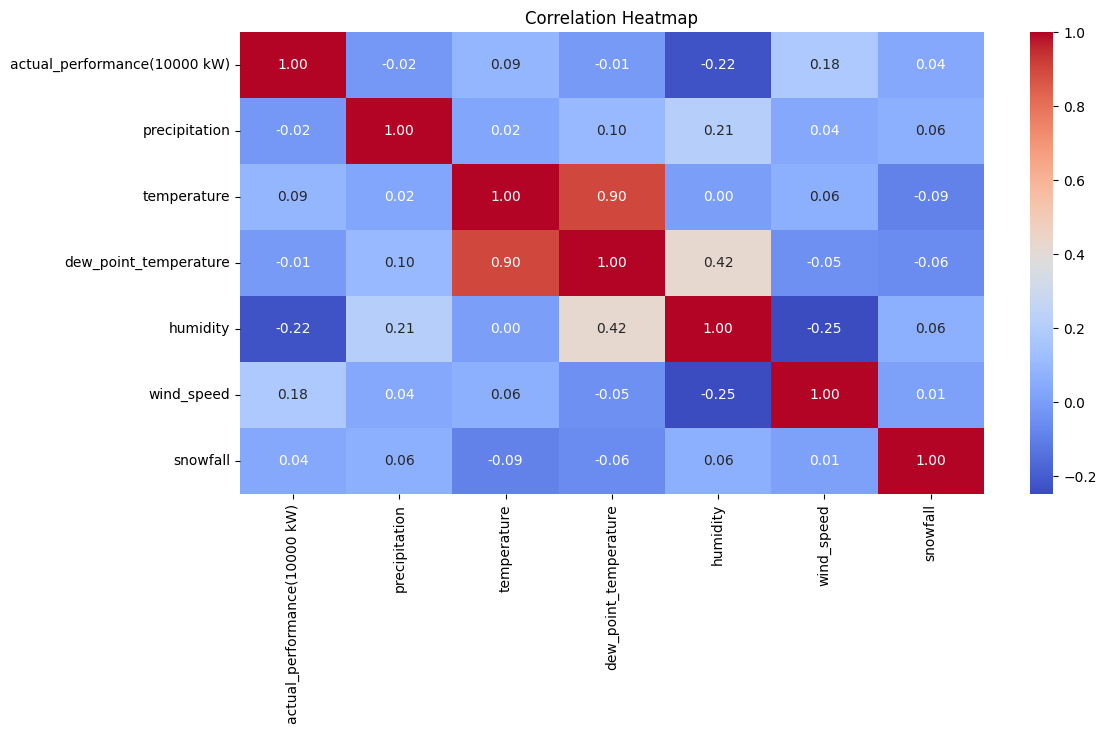

In [15]:
# Multivariate Analysis - Correlation Heatmap
plt.figure(figsize=(12, 6))

# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=['number'])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Correlation Heatmap')
plt.show()


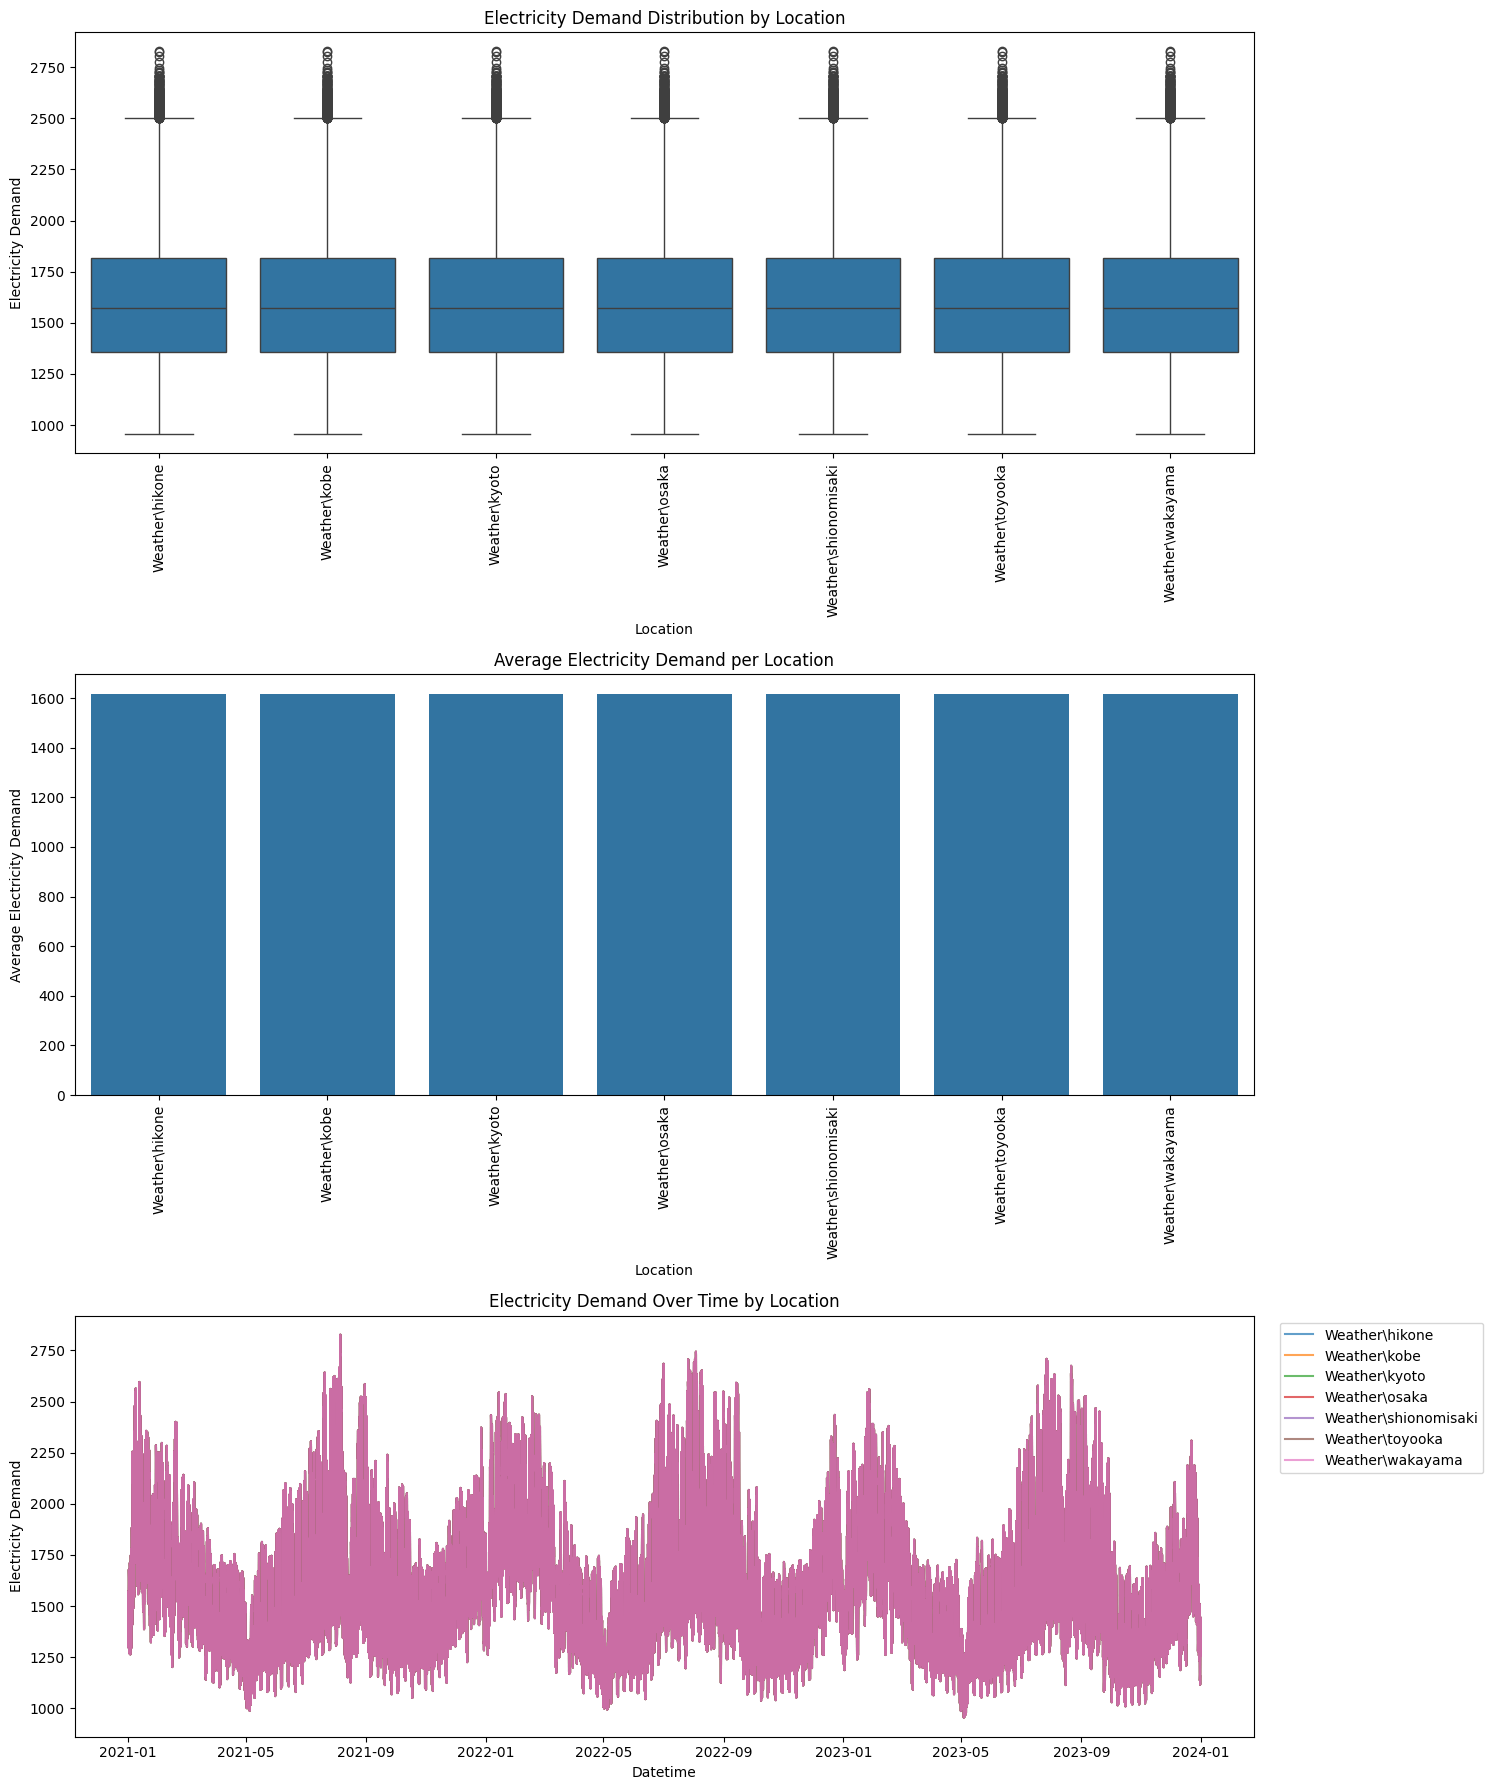

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# 1. Box Plot: Electricity Demand Distribution by Location
sns.boxplot(x='location', y='actual_performance(10000 kW)', data=data, ax=axes[0])
axes[0].set_title('Electricity Demand Distribution by Location')
axes[0].set_xlabel('Location')
axes[0].set_ylabel('Electricity Demand')
axes[0].tick_params(axis='x', rotation=90)

# 2. Bar Plot: Average Electricity Demand per Location
mean_demand_per_location = data.groupby('location')['actual_performance(10000 kW)'].mean().sort_values()
sns.barplot(x=mean_demand_per_location.index, y=mean_demand_per_location.values, ax=axes[1])
axes[1].set_title('Average Electricity Demand per Location')
axes[1].set_xlabel('Location')
axes[1].set_ylabel('Average Electricity Demand')
axes[1].tick_params(axis='x', rotation=90)

# 3. Line Plot: Electricity Demand Over Time by Location
for loc in data['location'].unique():
    subset = data[data['location'] == loc]
    axes[2].plot(subset['datetime'], subset['actual_performance(10000 kW)'], label=loc, alpha=0.7)

axes[2].legend(loc='upper right', bbox_to_anchor=(1.2, 1))
axes[2].set_title('Electricity Demand Over Time by Location')
axes[2].set_xlabel('Datetime')
axes[2].set_ylabel('Electricity Demand')

plt.tight_layout()
plt.show()


C:\Users\junjo\AppData\Local\Temp\ipykernel_2828\694376791.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=mi_results['Feature'], x=mi_results['MI Score'], palette='coolwarm')


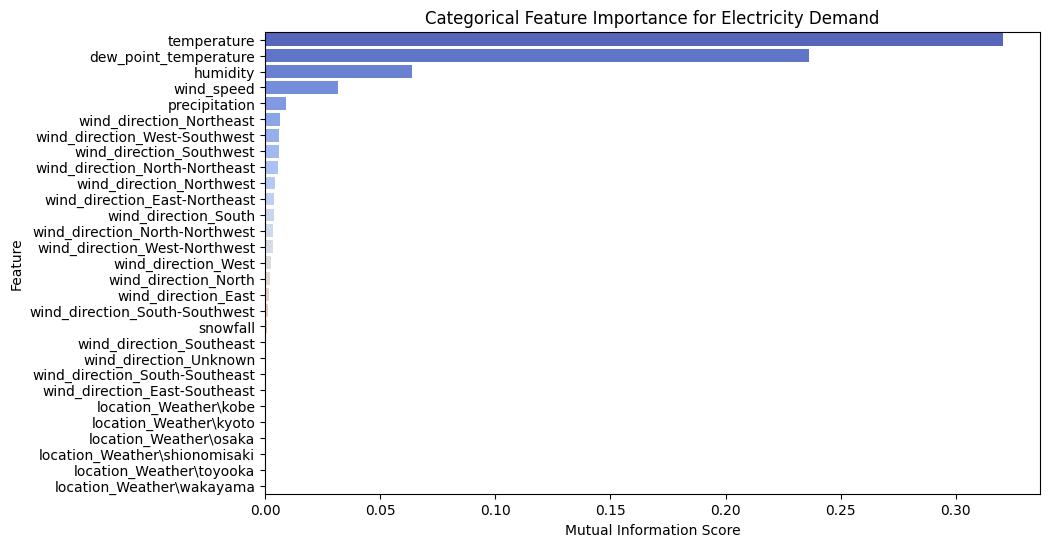

In [18]:
from sklearn.feature_selection import mutual_info_regression

# Select categorical columns
cat_cols = data.select_dtypes(include=['object']).columns

# Encode categorical variables (one-hot or label encoding)
data_encoded = pd.get_dummies(data, columns=cat_cols, drop_first=True)

# Compute Mutual Information
X_cat = data_encoded.drop(columns=['actual_performance(10000 kW)', 'datetime'])
y = data_encoded['actual_performance(10000 kW)']
mi_scores = mutual_info_regression(X_cat, y, random_state=42)

# Convert results to DataFrame
mi_results = pd.DataFrame({'Feature': X_cat.columns, 'MI Score': mi_scores})
mi_results = mi_results.sort_values(by='MI Score', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(y=mi_results['Feature'], x=mi_results['MI Score'], palette='coolwarm')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Categorical Feature Importance for Electricity Demand')
plt.show()


In [19]:
# Feature Engineering
data['hour'] = data['datetime'].dt.hour
data['dayofweek'] = data['datetime'].dt.dayofweek
data['month'] = data['datetime'].dt.month
data['lag_1'] = data['actual_performance(10000 kW)'].shift(1)  # Previous hour's demand
data.dropna(inplace=True)

In [20]:
data.head(5)

,datetime,actual_performance(10000 kW),precipitation,temperature,dew_point_temperature,humidity,wind_speed,wind_direction,snowfall,location,hour,dayofweek,month,lag_1
1,2021-01-01,1571,0.0,2.2,-3.7,65.0,5.7,West,0.0,Weather\kobe,0,4,1,1571.0
2,2021-01-01,1571,0.0,0.6,-5.0,66.0,2.1,South-Southwest,0.0,Weather\kyoto,0,4,1,1571.0
3,2021-01-01,1571,0.0,3.1,-4.1,59.0,4.8,West-Southwest,0.0,Weather\osaka,0,4,1,1571.0
4,2021-01-01,1571,0.0,3.7,-4.2,56.0,6.7,West-Northwest,0.0,Weather\shionomisaki,0,4,1,1571.0
5,2021-01-01,1571,0.5,-0.3,-0.4,99.0,2.1,South-Southeast,1.0,Weather\toyooka,0,4,1,1571.0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183959 entries, 1 to 183959
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   datetime                      183959 non-null  datetime64[ns]
 1   actual_performance(10000 kW)  183959 non-null  int64         
 2   precipitation                 183959 non-null  float64       
 3   temperature                   183959 non-null  float64       
 4   dew_point_temperature         183959 non-null  float64       
 5   humidity                      183959 non-null  float64       
 6   wind_speed                    183959 non-null  float64       
 7   wind_direction                183959 non-null  object        
 8   snowfall                      183959 non-null  float64       
 9   location                      183959 non-null  object        
 10  hour                          183959 non-null  int32         
 11  dayofweek         

In [22]:
data.describe()

,datetime,actual_performance(10000 kW),precipitation,temperature,dew_point_temperature,humidity,wind_speed,snowfall,hour,dayofweek,month,lag_1
count,183959,183959.000000,183959.000000,183959.000000,183959.000000,183959.000000,183959.000000,183959.000000,183959.000000,183959.000000,183959.000000,183959.000000
mean,2022-07-02 11:34:17.134469888,1616.426427,0.191284,17.073153,11.347330,70.890900,2.902546,0.004664,11.500063,3.005474,6.526057,1616.428128
min,2021-01-01 00:00:00,955.000000,0.000000,-6.300000,-17.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,955.000000
25%,2021-10-01 18:00:00,1359.000000,0.000000,10.000000,3.400000,58.000000,1.400000,0.000000,6.000000,1.000000,4.000000,1359.000000
50%,2022-07-02 12:00:00,1572.000000,0.000000,17.400000,11.300000,72.000000,2.500000,0.000000,12.000000,3.000000,7.000000,1572.000000
75%,2023-04-02 05:30:00,1816.000000,0.000000,24.500000,20.100000,85.000000,3.900000,0.000000,17.500000,5.000000,10.000000,1816.000000
max,2023-12-31 23:00:00,2827.000000,64.000000,38.400000,28.000000,100.000000,22.500000,7.000000,23.000000,6.000000,12.000000,2827.000000
std,NaN,328.182422,1.221276,8.673137,9.192216,17.184644,1.958725,0.103537,6.922172,2.000459,3.447846,328.181375


In [25]:
data.to_csv('dataset1.csv', index=False, header=False, encoding='utf-8')